In [1]:
import sys

sys.argv = ['']
sys.path.append("../..")
from src.grid_world import GridWorld
from examples.agent import Agent
import torch.nn as nn
from torch.optim import Optimizer
from torch import optim
import random
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F

In [2]:
class QNet(nn.Module):
    """
    Q(s, a) 网络
    输入: 状态one-hot向量（num_states维）
    输出: 所有动作的Q值（num_actions维）
    """

    def __init__(self, num_states, num_actions):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(num_states, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
class Sarsa(Agent):
    def __init__(self, env, num_episodes=5000, episode_length=1000,
                 gamma=0.9, alpha=1e-2, epsilon=0.1):
        super().__init__(
            env=env,
            epsilon=epsilon,
            gamma=gamma,
            num_episodes=num_episodes,
            episode_length=episode_length
        )

        self.alpha = alpha
        # 初始化Q网络（输入为状态one-hot维度）
        self.QNet = QNet(self.num_states, self.num_actions)
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.QNet.parameters(), lr=alpha)  # 改用Adam优化器


    def run(self):
        """
        执行强化学习主训练循环
        将整个训练过程分为10个迭代阶段，每个阶段显示进度条，定期输出奖励统计
        """
        # 计算每个迭代的episode数量（确保为整数）
        episodes_per_iteration = int(self.num_episodes / 10)

        # 遍历10个迭代阶段
        for iteration in range(10):
            # 初始化进度条，明确显示当前迭代轮次
            progress_desc = f"Iteration {iteration + 1}/10"
            with tqdm(total=episodes_per_iteration, desc=progress_desc, unit='episode') as pbar:

                # 遍历当前迭代的所有episode
                for episode_idx in range(episodes_per_iteration):
                    # 计算全局的episode编号
                    global_episode = iteration * episodes_per_iteration + episode_idx + 1

                    # 重置环境并获取初始状态
                    self.env.reset()
                    current_state = self.env.start_state
                    current_state_idx = self.state2idx(current_state)
                    current_action_idx = self.choose_action(current_state_idx)

                    # 初始化本轮奖励和步数
                    episode_reward = 0
                    step_count = 0

                    # 单轮episode的主循环
                    while step_count < self.episode_length:
                        # 执行选定的动作
                        current_action = self.idx2action(current_action_idx)
                        next_state, reward, done, _ = self.env.step(current_action)

                        # 转换状态和选择下一个动作
                        next_state_idx = self.state2idx(next_state)
                        next_action_idx = self.choose_action(next_state_idx)

                        # 累计奖励
                        episode_reward += reward

                        # 更新Q表和策略
                        self.update(current_state_idx, current_action_idx, reward, next_state_idx, next_action_idx, done)
                        self.update_policy(current_state_idx)

                        # 终止条件判断
                        if done:
                            break

                        # 迭代更新状态和动作
                        current_state_idx = next_state_idx
                        current_action_idx = next_action_idx
                        step_count += 1

                    # 每10个episode更新一次进度条的附加信息
                    if global_episode % 10 == 0:
                        pbar.set_postfix({
                            'episode': f"{global_episode}",
                            'return': f"{episode_reward:.3f}"
                        })

                    # 更新进度条
                    pbar.update(1)

    def update(self, s, a, r, s_next, a_next, done):
        """
        修正的Sarsa更新规则
        """
        # 关键修复：确保张量是整数类型（int64），并添加边界检查
        # 检查状态索引是否有效
        if not (0 <= s < self.num_states):
            raise ValueError(f"Invalid state index: {s}, num_states={self.num_states}")
        if not (0 <= s_next < self.num_states):
            raise ValueError(f"Invalid next state index: {s_next}, num_states={self.num_states}")

        # 显式指定张量类型为torch.long（int64），这是one_hot要求的索引类型
        s_tensor = torch.tensor(s, dtype=torch.long)
        s_next_tensor = torch.tensor(s_next, dtype=torch.long)

        # 状态one-hot编码（正确的输入方式）
        s_onehot = F.one_hot(s_tensor, num_classes=self.num_states).float().unsqueeze(0)
        s_next_onehot = F.one_hot(s_next_tensor, num_classes=self.num_states).float().unsqueeze(0)

        # 当前Q值（仅选当前动作的Q值）
        q_values = self.QNet(s_onehot)
        q_value = q_values[0, a].unsqueeze(0)

        # 计算TD目标
        with torch.no_grad():
            if done:
                td_target = torch.tensor([r], dtype=torch.float)
            else:
                q_next_values = self.QNet(s_next_onehot)
                q_next_value = q_next_values[0, a_next]
                td_target = torch.tensor([r], dtype=torch.float) + self.gamma * q_next_value

        # 损失计算与反向传播
        loss = self.loss_fn(q_value, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 更新Q表（同步网络输出）
        self.Q[s, a] = q_value.item()

        return loss.item()

    def update_policy(self, st_idx):
        """
        基于当前Q值更新ε-贪婪策略
        """
        # 检查状态索引有效性
        if not (0 <= st_idx < self.num_states):
            raise ValueError(f"Invalid state index: {st_idx}, num_states={self.num_states}")

        # 显式指定张量类型为torch.long
        st_tensor = torch.tensor(st_idx, dtype=torch.long)
        # 用网络计算当前状态的所有动作Q值
        s_onehot = F.one_hot(st_tensor, num_classes=self.num_states).float().unsqueeze(0)
        with torch.no_grad():
            q_values = self.QNet(s_onehot).squeeze(0).numpy()

        # 贪婪动作
        greedy_action = np.argmax(q_values)

        # 更新策略
        for a in range(self.num_actions):
            if a == greedy_action:
                self.policy[st_idx, a] = 1 - self.epsilon + (self.epsilon / self.num_actions)
            else:
                self.policy[st_idx, a] = self.epsilon / self.num_actions


In [4]:
env = GridWorld()
env.reward_step = -1
env.reward_target = 10

Iteration 10/10: 100%|██████████| 500/500 [00:14<00:00, 34.00episode/s, episode=5000, return=-11.000]


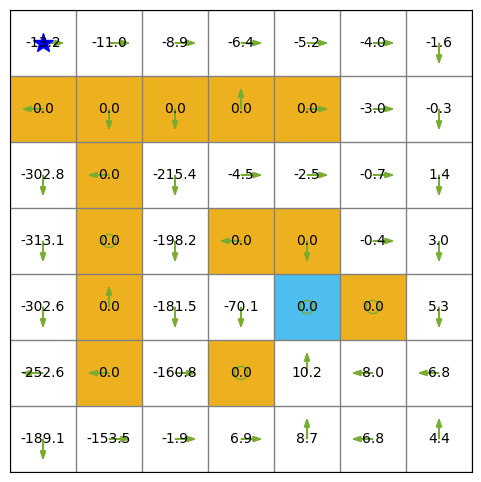

In [5]:
agent = Sarsa(env, epsilon=0.3, gamma=1, num_episodes=5000, episode_length=1000, alpha=1e-3)
agent.run()
agent.render_static()